In [1]:
import numpy as np
import tensorflow as tf
from utils_functions import *
from plan import *
import random
from main import *

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.utils  import plot_model
from tensorflow.keras.utils  import Sequence
import datetime, os

#from matplotlib import pyplot as plt
import optuna



c:\Users\Francesco\anaconda3\envs\Deep\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# controllo di star effettivamente usando la GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
print("nome gpu: ",tf.test.gpu_device_name())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
nome gpu:  /device:GPU:0


## Preparazione dati

### Caricamento dataset statici

### AE classico

In [2]:
test=load_file("./Dataset/set_test")
train=load_file("./Dataset/set_training")
validation=load_file("./Dataset/set_validation")

test=np.array(test,dtype=np.int8)
train=np.array(train,dtype=np.int8)
validation=np.array(validation,dtype=np.int8)
 

File loaded
File loaded
File loaded


### AE 2 teste

In [12]:
test=load_file("./Dataset/set_test_v2")
train=load_file("./Dataset/set_training_v2")
validation=load_file("./Dataset/set_validation_v2")




File loaded
File loaded
File loaded


## Modello

### Optuna 

In [ ]:
def objective(trial):
    input_dim=340
    num_hidden1=170
    code=34
    ae = tf.keras.models.Sequential()
    #tf.keras.regularizers.L2(reg)
    #n_layers=trial.suggest_int('n_layers', 1, 3)
    #num_hidden1 = trial.suggest_int('n_units_hidden', 68,170,1,log=True)
    l_rate=trial.suggest_float("weight_decay", 1e-7, 5e-3, log=True)
    reg=trial.suggest_float("weight_decay", 1e-10, 1e-5, log=True)
    #code= trial.suggest_int('n_units_embedded', 4,34,1,log=True)

    ae.add(Input(shape=(input_dim,)))
    ae.add(tf.keras.layers.Dense(num_hidden1, activation='relu',kernel_initializer="he_uniform",kernel_regularizer=tf.keras.regularizers.L1(reg)))     
    #ae.add(tf.keras.layers.BatchNormalization())
    ae.add(tf.keras.layers.Dense(code, activation='relu', kernel_initializer="he_uniform",kernel_regularizer=tf.keras.regularizers.L1(reg))) 
   #ae.add(tf.keras.layers.BatchNormalization())
    ae.add(tf.keras.layers.Dense(num_hidden1, activation='relu',kernel_initializer="he_uniform",kernel_regularizer=tf.keras.regularizers.L1(reg))) 
    #ae.add(tf.keras.layers.BatchNormalization())
    ae.add(tf.keras.layers.Dense(input_dim, activation='sigmoid',kernel_initializer=tf.keras.initializers.GlorotUniform()))

    callback = [tf.keras.callbacks.EarlyStopping(patience=10)]
    ae.compile(optimizer=tf.keras.optimizers.Adam(l_rate), loss='binary_crossentropy',metrics=["accuracy","Precision","Recall"])


    history=ae.fit(x=train,y=train, epochs=500,batch_size=5000, validation_data=(validation,validation),callbacks=callback)

    optuna_dir= os.path.join("./optunaLogs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    optuna_dir=os.path.join(optuna_dir, str(trial.number))
    ae.save(optuna_dir)

    #return history.history["val_precision"][-1],history.history["val_recall"][-1]
    return history.history["loss"][-1]

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20, timeout=None, gc_after_trial=True)

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))



### AutoEncoder Base

In [ ]:

logdir = os.path.join("./TestLogs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True, write_images=True)

]



#PARAM:
#tf.keras.regularizers.L1(l1=1e-4)
param={"INPUT_SIZE" : 340,
"HIDDEN_SIZE" : 170,
"HIDDEN_SIZE2" : None,
"HIDDEN_SIZE3" : None,
"CODE_SIZE" : 34,
"KERNEL_INIZIALIZER":"he_uniform",
"KERNEL_REGULIZER":tf.keras.regularizers.L2(l2=1e-6),
'BIAS_REGULARIZER': None,
"ACTIVATION":'relu',
"OPTIMIZER":tf.keras.optimizers.Adam(learning_rate=0.0002),
"EPOCHS":3000,
"BATCH_SIZE":5000,
"BATCH_NORMAIZATION": 0
}

autoencoder=tf.keras.models.Sequential()

autoencoder.add(Input(shape=(param["INPUT_SIZE"],)))

autoencoder.add( Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))

autoencoder.add(Dense(param["CODE_SIZE"], activation=param["ACTIVATION"],kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"],bias_regularizer=param["BIAS_REGULARIZER"],name="code"))

autoencoder.add(Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))

autoencoder.add( Dense(param["INPUT_SIZE"], activation='sigmoid'))


#variare learning_rate beta_1,beta_2, da fare per ultimo
#batch_size ???
autoencoder.compile(optimizer=param["OPTIMIZER"], loss='binary_crossentropy',metrics=["accuracy","Precision","Recall"])
history=autoencoder.fit(x=train,y=train, epochs=param["EPOCHS"],batch_size=param["BATCH_SIZE"], validation_data=(validation,validation), 
                        callbacks=my_callbacks)

 #Gardare i risulati delle metriche su tensorbord                      

### Autoencoder LSTM, 2 teste

In [ ]:
dim_vett=340
n_vett=00
# encoder
input_layer = Input(shape=(n_vett,dim_vett))
encoder = LSTM(100, )(input_layer)
# reconstruct decoder
decoder1 = RepeatVector(n_in)(encoder)
decoder1 = LSTM(100,  return_sequences=True)(decoder1)
decoder1 = TimeDistributed(Dense(1))(decoder1)
# predict decoder
decoder2 = RepeatVector(n_out)(encoder)
decoder2 = LSTM(100,  return_sequences=True)(decoder2)
decoder2 = TimeDistributed(Dense(n_input,activation=""))(decoder2)
# tie it together
model = Model(inputs=input_layer, outputs=[decoder1, decoder2])
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy","Precision","Recall"])

### Print and Test ae

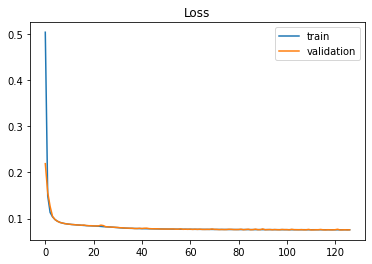

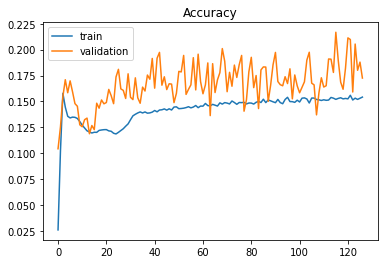

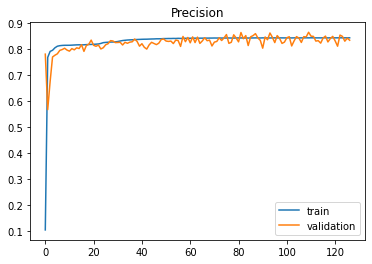

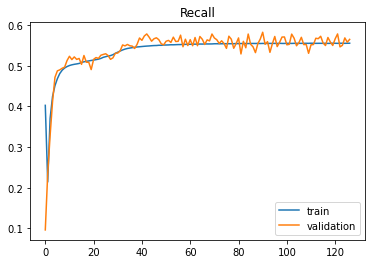

In [39]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss")
plt.show()
    
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='validation')
plt.legend()
plt.title("Precision")
plt.show()

plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='validation')
plt.legend()
plt.title("Recall")
plt.show()




In [10]:
#val_predictions = autoencoder.predict(validation)
test_predictions = autoencoder.predict(test)

7211/7211 [==============================] - 10s 1ms/step


In [20]:
print(test[10000])
print(np.round(test_predictions[10000]))

[0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0

In [ ]:
arr=results_info(test,test_predictions,logdir) 

Salva modello

In [17]:
#Se i risultati sono buoni salva il modello in modo che possa essere riusato

dir_model= os.path.join(logdir,"myModel")
autoencoder.save(dir_model)

autoencoder.summary()

INFO:tensorflow:Assets written to: ./TestLogs/20220625-123155\myModel\assets


Carica modello

In [15]:
#CARICA AUTOENCODER SALVATO

PATH_TO_LOAD="./TestLogs/20220625-123155/myModel"
autoencoder = tf.keras.models.load_model(PATH_TO_LOAD)

In [10]:
#%tensorboard --logdir logsTf
%load_ext tensorboard
#Avvio da terminale: spostarsi nella cartella dove è presente la cartella di log, > tensorboard --logdir nomecartella